# Implémentez un modèle de scoring

In [23]:
# Libraries
import pandas as pd
import numpy as np
import warnings
import os
import pickle
import gc
import time
from contextlib import contextmanager
from urllib.parse import urlparse
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,classification_report,recall_score,precision_score,balanced_accuracy_score,f1_score,confusion_matrix
from sklearn.utils import class_weight
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import shap
import joblib
from mlflow.models.signature import infer_signature

# Disabling warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
# Reading the CSV file and sampling 2000 rows
df_sample = pd.read_csv(os.path.join('..', 'data', 'preprocessed_data.csv')).sample(2000)

# Displaying the first few rows of the sampled DataFrame
df_sample.head()


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
7244,0.0,Cash loans,0,1,0,0,306000.0,2013840.0,53253.0,1800000.0,...,45943.502500,826983.045,45793.350,45952.335,45943.502500,826983.045,-185.0,-441.388889,-7945.0,18.0
10033,0.0,Cash loans,1,0,0,0,112500.0,1041219.0,44113.5,855000.0,...,4713.450000,28280.700,4696.020,4716.900,4713.420000,28280.520,-2245.0,-2320.333333,-13922.0,6.0
564,0.0,Cash loans,1,0,0,2,58500.0,71955.0,7006.5,67500.0,...,39906.868235,678416.760,4458.240,475312.050,39906.868235,678416.760,-48.0,-1317.176471,-22392.0,17.0
16417,0.0,Cash loans,0,0,0,0,157500.0,454500.0,24214.5,454500.0,...,12644.546186,746028.225,3618.000,32674.365,13208.190254,779283.225,-15.0,-1028.406780,-60676.0,59.0
8082,0.0,Cash loans,0,0,0,0,247500.0,1574788.5,43434.0,1233000.0,...,64591.416643,4521399.165,13425.255,615383.910,88495.713000,6194699.910,-38.0,-621.128571,-43479.0,70.0


In [3]:
df_sample[df_sample['TARGET'] == 1.0].head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
6296,1.0,Cash loans,1,0,0,0,90000.0,331834.5,14746.5,252000.0,...,9820.813500,98208.135,9791.370,9824.085,9820.813500,98208.135,-709.0,-837.700000,-8377.0,10.0
200,1.0,Cash loans,0,1,0,0,157500.0,592560.0,35937.0,450000.0,...,4128.904286,57804.660,0.765,4136.265,3538.009286,49532.130,-818.0,-1002.285714,-14032.0,14.0
10602,1.0,Cash loans,1,0,1,0,90000.0,269550.0,21739.5,225000.0,...,9469.568571,132573.960,14.760,10161.810,7292.037857,102088.530,-517.0,-633.285714,-8866.0,14.0
6516,1.0,Cash loans,1,0,0,2,90000.0,545040.0,25537.5,450000.0,...,8815.865000,79342.785,0.315,15481.305,7041.935000,63377.415,-1256.0,-1333.444444,-12001.0,9.0
7456,1.0,Cash loans,1,0,0,0,90000.0,545040.0,25537.5,450000.0,...,19482.189231,253268.460,3033.900,135000.000,29866.804615,388268.460,-20.0,-1120.692308,-14569.0,13.0


In [4]:
df_sample[df_sample['TARGET'] == 0.0].head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
7244,0.0,Cash loans,0,1,0,0,306000.0,2013840.0,53253.0,1800000.0,...,45943.502500,826983.045,45793.350,45952.335,45943.502500,826983.045,-185.0,-441.388889,-7945.0,18.0
10033,0.0,Cash loans,1,0,0,0,112500.0,1041219.0,44113.5,855000.0,...,4713.450000,28280.700,4696.020,4716.900,4713.420000,28280.520,-2245.0,-2320.333333,-13922.0,6.0
564,0.0,Cash loans,1,0,0,2,58500.0,71955.0,7006.5,67500.0,...,39906.868235,678416.760,4458.240,475312.050,39906.868235,678416.760,-48.0,-1317.176471,-22392.0,17.0
16417,0.0,Cash loans,0,0,0,0,157500.0,454500.0,24214.5,454500.0,...,12644.546186,746028.225,3618.000,32674.365,13208.190254,779283.225,-15.0,-1028.406780,-60676.0,59.0
8082,0.0,Cash loans,0,0,0,0,247500.0,1574788.5,43434.0,1233000.0,...,64591.416643,4521399.165,13425.255,615383.910,88495.713000,6194699.910,-38.0,-621.128571,-43479.0,70.0


In [5]:
# Checking the shape of the sampled DataFrame
df_sample.shape


(2000, 429)

In [6]:
from contextlib import contextmanager

# Custom context manager for measuring execution time
@contextmanager
def timer(title):
    # Start time
    t0 = time.time()
    
    yield
    
    # Calculate and print elapsed time
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Fonctions

In [7]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    # Store the original columns of the DataFrame
    original_columns = list(df.columns)
    
    # Identify categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Perform one-hot encoding using get_dummies
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    
    # Retrieve the newly created columns
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns


In [8]:
def column_names(data):
    # Initialize lists for categorical and numerical column names
    categorical_list = []
    numerical_list = []
    
    # Iterate over columns of the DataFrame
    for i in data.columns.tolist():
        # Check if the column is of object type (categorical)
        if data[i].dtype == 'object':
            categorical_list.append(i)
        else:
            numerical_list.append(i)

    # Get the names of the categories
    cat = preprocessor.transformers_[1][1].get_feature_names(categorical_list)

    # Concatenate numerical and categorical column names
    column_names = numerical_list + cat.tolist()
    
    return column_names


In [9]:
def numerical_list(df):
    # Initialize lists for categorical and numerical column names
    categorical_list = []
    numerical_list = []
    
    # Iterate over columns of the DataFrame
    for i in df.columns.tolist():
        # Check if the column is of object type (categorical)
        if df[i].dtype == 'object':
            categorical_list.append(i)
        else:
            numerical_list.append(i)
    
    return numerical_list


In [10]:
def categorical_list(df):
    # Initialize lists for categorical and numerical column names
    categorical_list = []
    numerical_list = []
    
    # Iterate over columns of the DataFrame
    for i in df.columns.tolist():
        # Check if the column is of object type (categorical)
        if df[i].dtype == 'object':
            categorical_list.append(i)
        else:
            numerical_list.append(i)
    
    return categorical_list


In [11]:
def eva_func(y_true, y_pred, fn_value=-10, fp_value=1, tp_value=1, tn_value=2):
    # Compute the confusion matrix
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Extract values from the confusion matrix
    tn = mat_conf[0, 0]  # True Negatives
    fn = mat_conf[1, 0]  # False Negatives
    fp = mat_conf[0, 1]  # False Positives
    tp = mat_conf[1, 1]  # True Positives
    
    # Calculate the total gain
    J = tp * tp_value + tn * tn_value + fp * fp_value + fn * fn_value
    
    # Calculate the maximum gain
    max_J = (fp + tn) * tn_value + (fn + tp) * tp_value
    
    # Calculate the minimum gain
    min_J = (fp + tn) * fp_value + (fn + tp) * fn_value
    
    # Normalize the gain between 0 and 1
    J_normalized = (J - min_J) / (max_J - min_J)
    
    return J_normalized  # Return the evaluation function


In [12]:
def plot_auc_roc(y, y_prob):
    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    
    # Compute the AUC score
    auc_score = roc_auc_score(y, y_prob)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the random curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Print the AUC-ROC score
    print('AUC-ROC Score: {:.4f}'.format(auc_score))


In [13]:
def plot_heatmap_confusion(y_test, y_pred):
    # Create a figure with the specified size
    plt.figure(1, figsize=(12, 4))
    
    # Create a dictionary to store the results
    results = {}
    
    # Compute the confusion matrix
    conf_mx = confusion_matrix(y_test, y_pred)
    
    # Store the confusion matrix in the results dictionary
    results = conf_mx
    
    # Create a DataFrame from the confusion matrix
    mat_conf_df = pd.DataFrame(conf_mx,
                               columns=["Solvable", "Non Solvable"],
                               index=["Solvable", "Non Solvable"])
    
    # Plot the heatmap of the confusion matrix
    sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g', cmap='YlOrBr')
    
    # Set the title and axis labels
    plt.title('Matrice de confusion')
    plt.ylim(0, 2)
    plt.xlabel("Classes prédites")
    plt.ylabel("Classes réelles")
    
    # Show the plot
    plt.show()


In [14]:
def eval_metrics(actual, pred):
    # Compute the balanced accuracy
    balance_accuracy = balanced_accuracy_score(actual, pred)
    
    # Compute the precision score
    pr = precision_score(actual, pred)
    
    # Compute the recall
    re = recall_score(actual, pred)
    
    # Compute the F1 score
    f1 = f1_score(actual, pred)
    
    # Compute the ROC AUC score
    roc_auc = roc_auc_score(actual, pred)
    
    # Compute the accuracy score
    accuracy_score = metrics.accuracy_score(actual, pred)
    
    # Compute the F-beta score
    fbeta_score = metrics.fbeta_score(actual, pred, beta=3)
    
    # Create a dictionary to store the evaluation metrics
    dictionary = {}
    dictionary['balance_accuracy'] = balance_accuracy
    dictionary['f1'] = f1
    dictionary['precision'] = pr
    dictionary['recall'] = re
    dictionary['roc_auc'] = roc_auc
    dictionary['accuracy_score'] = accuracy_score
    dictionary['fbeta_score'] = fbeta_score
    
    return dictionary


In [15]:
X_sample = df_sample.drop('TARGET',axis=1)
y_sample = df_sample['TARGET']

In [16]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, stratify=y_sample, train_size=0.8)



In [17]:
# Combine X_test_sample and y_test_sample
data_to_export = X_test_sample.join(y_test_sample)
data_to_export.head(5)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
6452,Cash loans,0,1,0,0,90000.0,1125000.0,46557.0,1125000.0,Family,...,211044.420,2900.025,19771.290,6395.285455,211044.420,-2589.0,-2773.121212,-91513.0,33.0,0.0
19006,Cash loans,1,0,0,0,67500.0,225000.0,12915.0,225000.0,Unaccompanied,...,207588.465,3956.580,15664.005,6696.402097,207588.465,-391.0,-840.225806,-26047.0,31.0,0.0
3983,Cash loans,1,0,0,0,112500.0,301500.0,21847.5,301500.0,Unaccompanied,...,617451.795,26.055,38214.000,7908.774324,585249.300,-12.0,-419.932432,-31075.0,74.0,0.0
486,Cash loans,0,0,1,0,99000.0,450000.0,20979.0,450000.0,Unaccompanied,...,30961.035,0.180,4426.335,3792.336429,26546.355,-2290.0,-2351.428571,-16460.0,7.0,0.0
18154,Cash loans,1,0,1,2,112500.0,1078200.0,28570.5,900000.0,Unaccompanied,...,661428.540,47.070,145813.725,16435.807297,608124.870,-37.0,-724.540541,-26808.0,37.0,0.0


In [18]:
# Save the test set
path_2 = os.path.join('..', 'data')
filename = os.path.join(path_2, 'sample_test_set.pickle')
with open(filename, 'wb') as outfile:
    pickle.dump(data_to_export, outfile)

# Pre-processing

In [19]:
numeric_features = numerical_list(X_sample)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features = categorical_list(X_sample)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Boderline-SMOTE data

In [20]:
preprocessor.fit(X_train_sample,y_train_sample)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CODE_GENDER', 'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                  'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLIS...
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2'

In [21]:
# Apply preprocessor to transform training data
X_train_prepro = preprocessor.transform(X_train_sample)

# Convert transformed data to DataFrame with column names
X_train_prepro = pd.DataFrame(X_train_prepro, columns=column_names(X_train_sample))


In [22]:
# Apply preprocessor to transform test data
X_test_prepro = preprocessor.transform(X_test_sample)

# Convert transformed data to DataFrame with column names
X_test_prepro = pd.DataFrame(X_test_prepro, columns=column_names(X_train_sample))


In [24]:
# Apply SMOTE to oversample the minority class
smote = BorderlineSMOTE(random_state=42, sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_resample(X_train_prepro, y_train_sample)


In [25]:
print('Prêt octroyé avant BorderlineSMOTE: {}'.format(y_train_sample[y_train_sample == 0].shape[0]))
print('Prêt non octroyé avant BorderlineSMOTE: {}'.format(y_train_sample[y_train_sample == 1].shape[0]))


Prêt octroyé avant BorderlineSMOTE: 1482
Prêt non octroyé avant BorderlineSMOTE: 118


In [26]:
print('Prêt octroyé après BorderlineSMOTE: {}'.format(y_train_sm[y_train_sm == 0].shape[0]))
print('Prêt non octroyé après BorderlineSMOTE: {}'.format(y_train_sm[y_train_sm == 1].shape[0]))


Prêt octroyé après BorderlineSMOTE: 1482
Prêt non octroyé après BorderlineSMOTE: 1482


# Random Under Sampling (RUS) data

In [27]:
# Applique RandomUnderSampler imbalanced data
sm = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_train_rus, y_train_rus = sm.fit_resample(X_train_prepro, y_train_sample)


In [28]:
print('Prêt octroyé avant RUS: {}'.format(y_train_sample[y_train_sample == 0].shape[0]))
print('Prêt non octroyé avant RUS: {}'.format(y_train_sample[y_train_sample == 1].shape[0]))

Prêt octroyé avant RUS: 1482
Prêt non octroyé avant RUS: 118


In [29]:
print('Prêt octroyé après RUS: {}'.format(y_train_rus[y_train_rus == 0].shape[0]))
print('Prêt non octroyé après RUS: {}'.format(y_train_rus[y_train_rus == 1].shape[0]))

Prêt octroyé après RUS: 118
Prêt non octroyé après RUS: 118


# Modeling

In [30]:
metier = metrics.make_scorer(eva_func,greater_is_better=True)

In [31]:
# Identify numeric features
numeric_features = numerical_list(X_sample)

# Create a pipeline for numeric data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Identify categorical features
categorical_features = categorical_list(X_sample)

# Create a transformer for categorical data
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [ ]:
model_metrics_dict = {}

In [32]:
def model_dummy(X_train_, X_test_, y_train_, y_test_):
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('Dummy Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name='dummy/test') as run:
            # Create an empty model
            cls = DummyClassifier()
            
            # Fit the model to the training data
            cls.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", cls.get_params)
            
            # Display model score
            print("Model score: %.3f" % cls.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = cls.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(cls, 'dummy', registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(cls, 'dummy')

# Start MLflow UI
# mlflow ui

In [33]:
# Imbalanced data
model_dummy(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

2023/07/01 14:35:50 INFO mlflow.tracking.fluent: Experiment with name 'Dummy Models' does not exist. Creating a new experiment.


Best params:
 <bound method BaseEstimator.get_params of DummyClassifier()>
Model score: 0.925
Time: 0.0


Successfully registered model 'CreditModels'.
2023/07/01 14:36:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 1
Created version '1' of model 'CreditModels'.


In [32]:
# Oversampling (SMOTE)
model_dummy(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier()>
Model score: 0.910
Time: 0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 2
Created version '2' of model 'CreditModels'.


In [33]:
# Undersampling (RUS)
model_dummy(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier()>
Model score: 0.910
Time: 0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 3
Created version '3' of model 'CreditModels'.


In [34]:
def model_dummy_rand(X_train_, X_test_, y_train_, y_test_):
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('Dummy Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name='dummy/uniform') as run:
            # Create an empty model with 'uniform' strategy
            cls = DummyClassifier(strategy='uniform')
            
            # Fit the model to the training data
            cls.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", cls.get_params)
            
            # Display model score
            print("Model score: %.3f" % cls.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = cls.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(cls, 'dummy', registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(cls, 'dummy')

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
Model score: 0.522
Time: 0.0


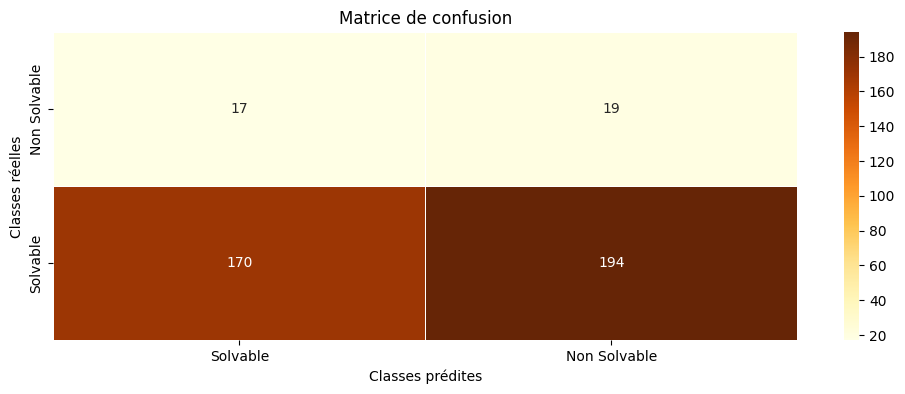

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 4
Created version '4' of model 'CreditModels'.


In [35]:
# Imbalanced data
model_dummy_rand(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
Model score: 0.522
Time: 0.0


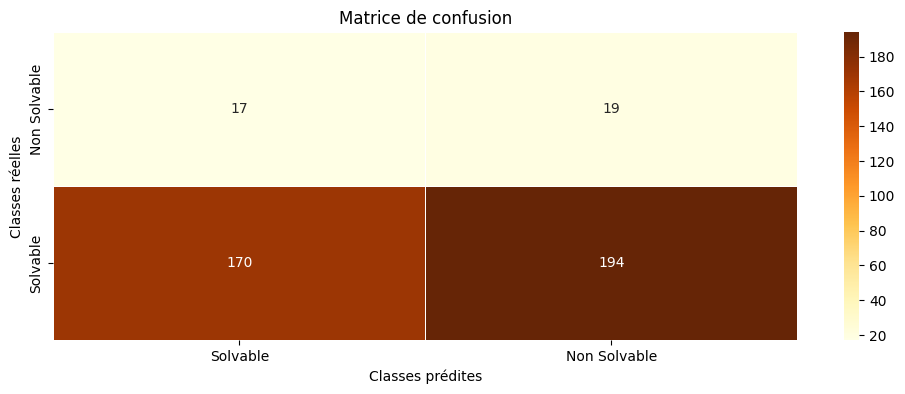

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 5
Created version '5' of model 'CreditModels'.


In [36]:
# Oversampling (SMOTE)
model_dummy_rand(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
Model score: 0.522
Time: 0.0


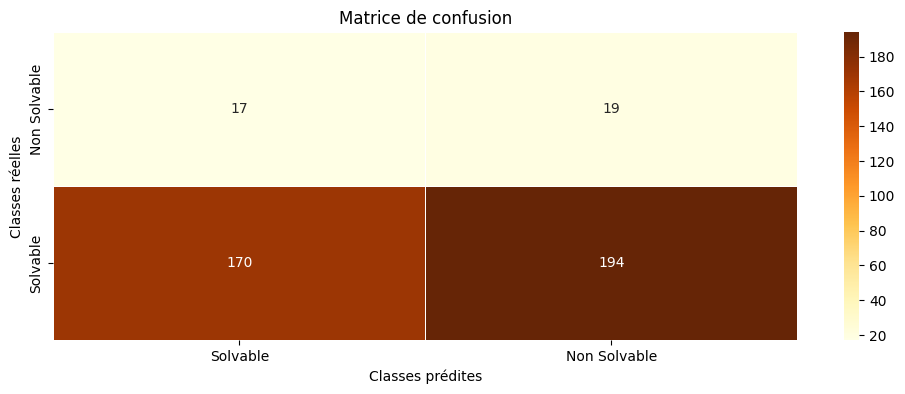

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 6
Created version '6' of model 'CreditModels'.


In [37]:
# Undersampling (RUS)
model_dummy_rand(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

In [38]:
def model_lr(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    # Set the params for LogisticRegression
    param_grid_lr = [
        {'solver': ['lbfgs'],
         'C': np.logspace(.5, 7.5, 8),
         'penalty': ['none']
        }
    ]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('LogReg Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name='logistic_regression/sample') as run:
            # Create an empty model
            if use_class_weights:
                cls = LogisticRegression(class_weight='balanced')
            else:
                cls = LogisticRegression()
            
            # Hyperparameter tuning
            grid_lr = GridSearchCV(estimator=cls,
                                   param_grid=param_grid_lr,
                                   return_train_score=True,
                                   error_score='raise',
                                   scoring=metier,  # Assuming 'metier' is defined elsewhere
                                   cv=5)
            
            # Fit the model to the training data
            grid_lr.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid_lr.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_lr.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid_lr.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid_lr.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_lr.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_lr, 'lr', registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_lr, 'lr')

2023/06/23 20:58:26 INFO mlflow.tracking.fluent: Experiment with name 'LogReg Models' does not exist. Creating a new experiment.


Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.601
Time: 7.0


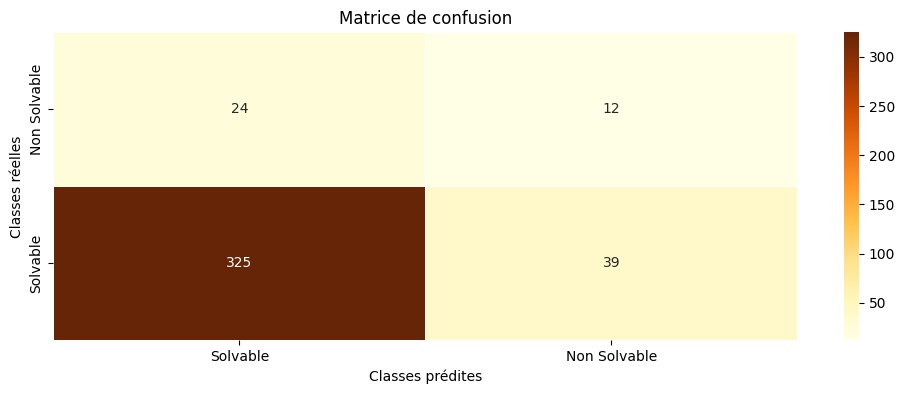

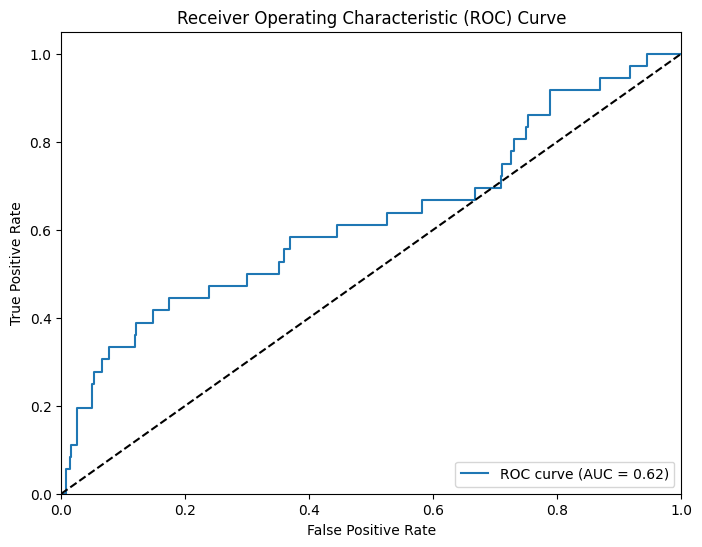

AUC-ROC Score: 0.6250


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 7
Created version '7' of model 'CreditModels'.


In [39]:
# Imbalanced data
model_lr(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.600
Time: 10.0


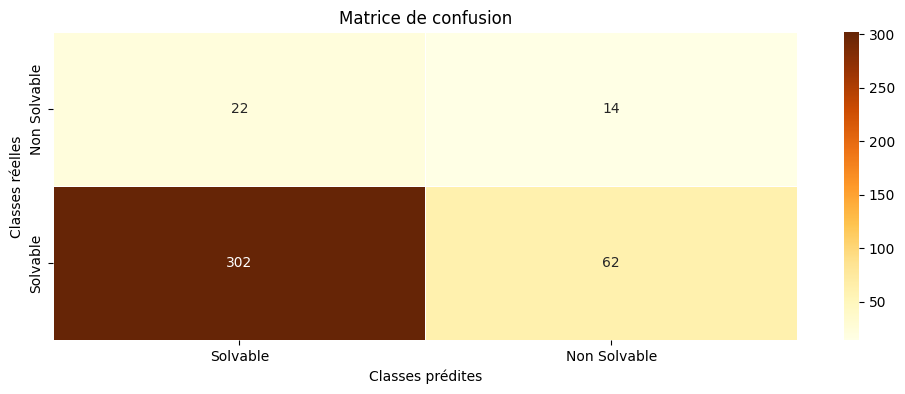

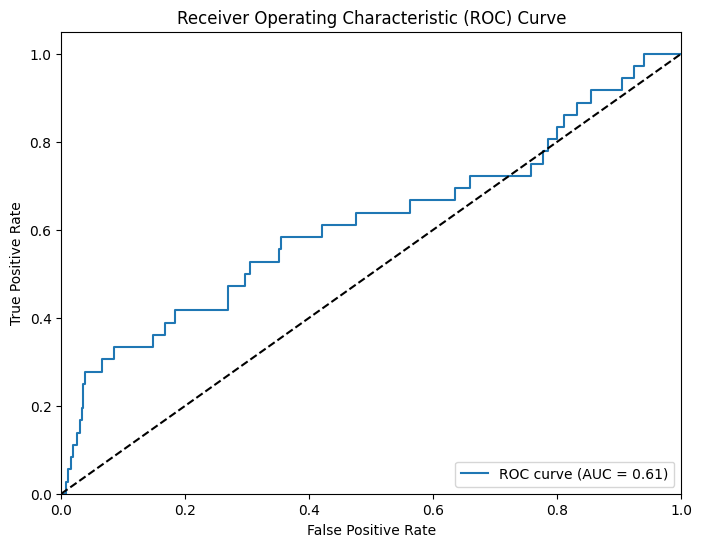

AUC-ROC Score: 0.6142


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:58:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 8
Created version '8' of model 'CreditModels'.


In [40]:
# Oversampling (SMOTE)
model_lr(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.650
Time: 2.0


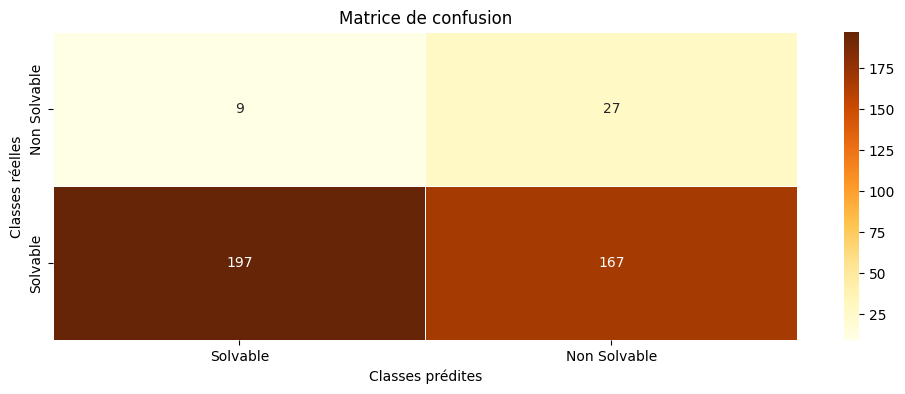

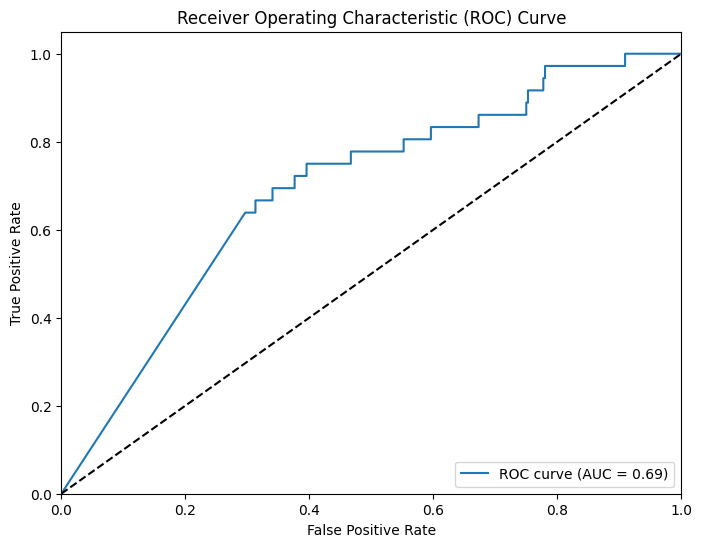

AUC-ROC Score: 0.6918


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:59:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 9
Created version '9' of model 'CreditModels'.


In [41]:
# Undersampling (RUS)
model_lr(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.592
Time: 7.0


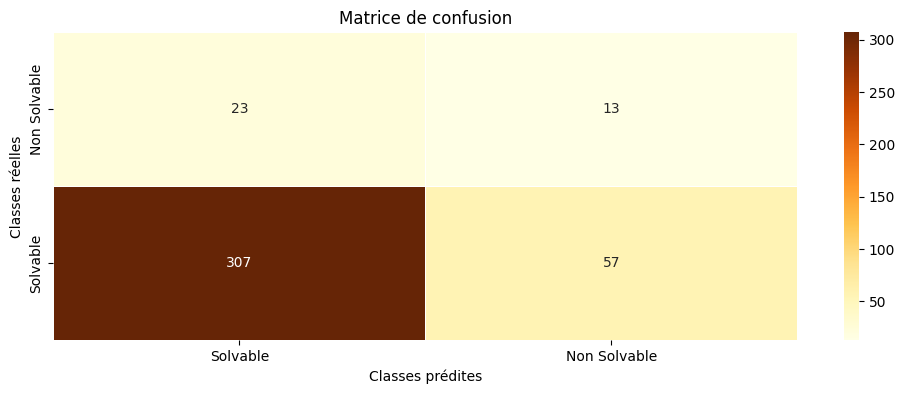

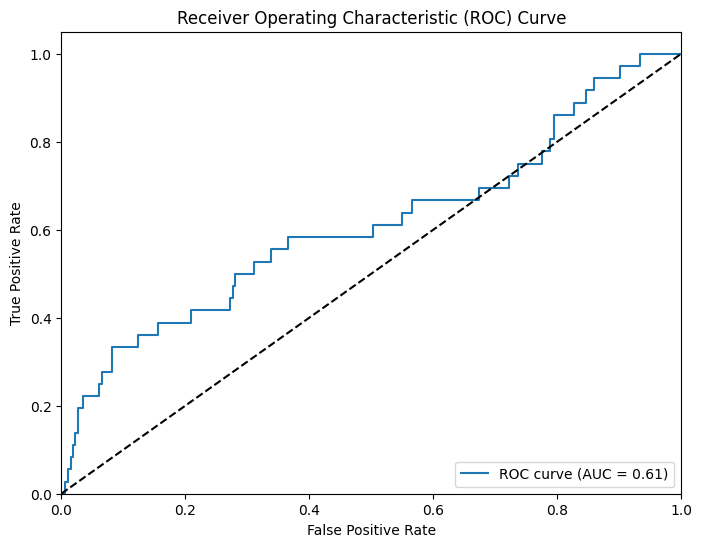

AUC-ROC Score: 0.6095


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:59:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 10
Created version '10' of model 'CreditModels'.


In [42]:
# class weight (balanced)
model_lr(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)

In [43]:
def model_knn(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'knn'
    # Params for NearestNeighbors
    param_grid = [{'n_neighbors': list(range(1, 31))}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('KNeighbors Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            if use_class_weights:
                cls = KNeighborsClassifier(weights='distance')
            else:
                cls = KNeighborsClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=metier,
                                cv=5)
            
            # Fit the model to the training data
            grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)

2023/06/23 20:59:15 INFO mlflow.tracking.fluent: Experiment with name 'KNeighbors Models' does not exist. Creating a new experiment.


Best params:
 {'n_neighbors': 1}
Model score: 0.464
Time: 29.0


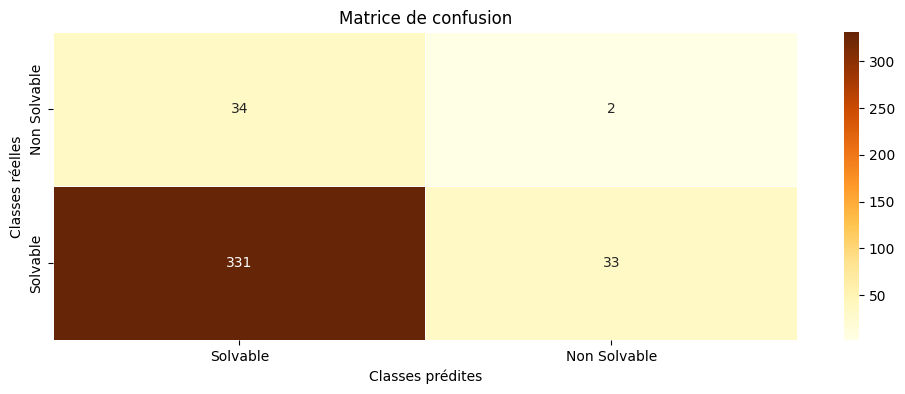

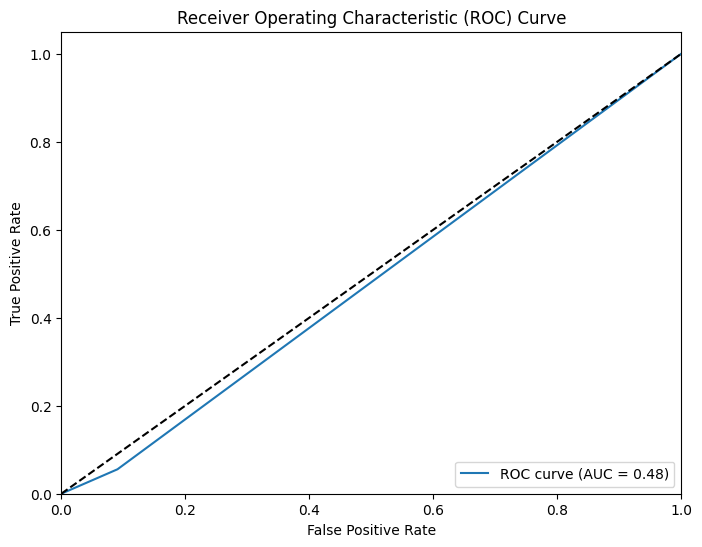

AUC-ROC Score: 0.4824


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 20:59:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 11
Created version '11' of model 'CreditModels'.


In [44]:
# Imbalanced data
model_knn(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'n_neighbors': 2}
Model score: 0.521
Time: 77.0


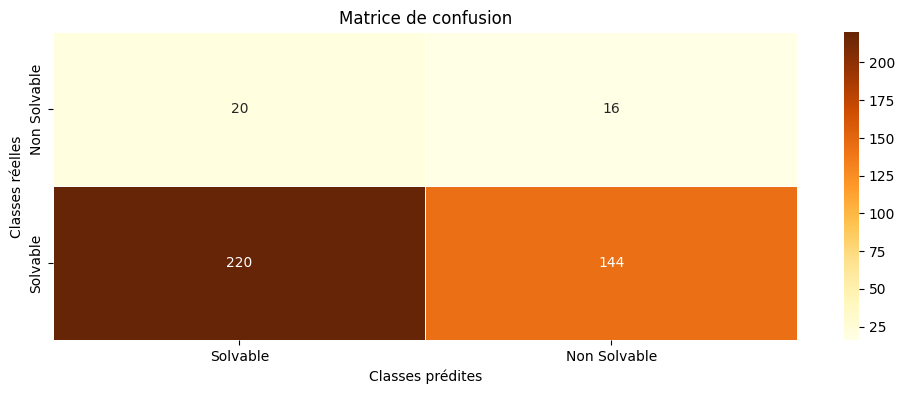

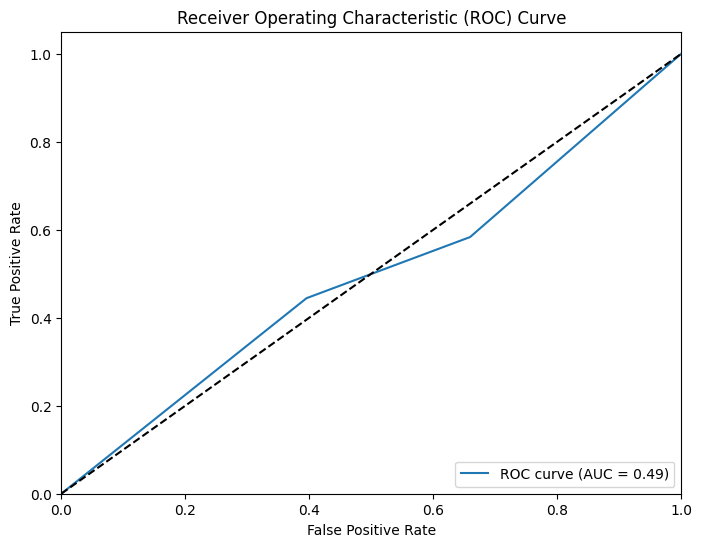

AUC-ROC Score: 0.4931


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:01:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 12
Created version '12' of model 'CreditModels'.


In [45]:
# Oversampling (SMOTE)
model_knn(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'n_neighbors': 5}
Model score: 0.564
Time: 6.0


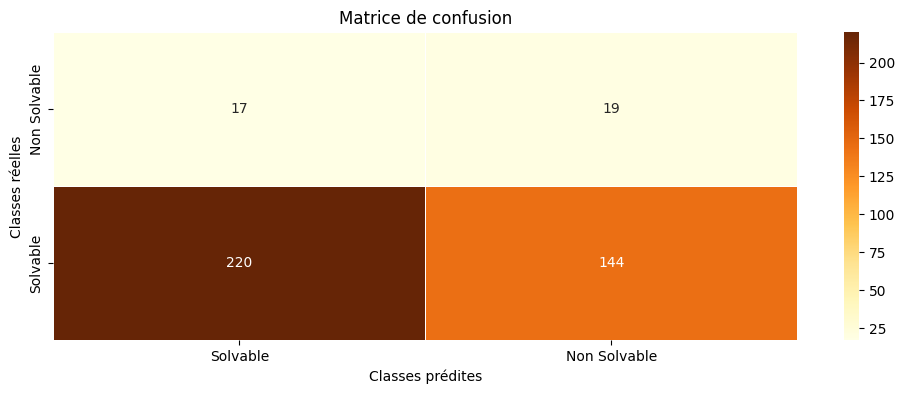

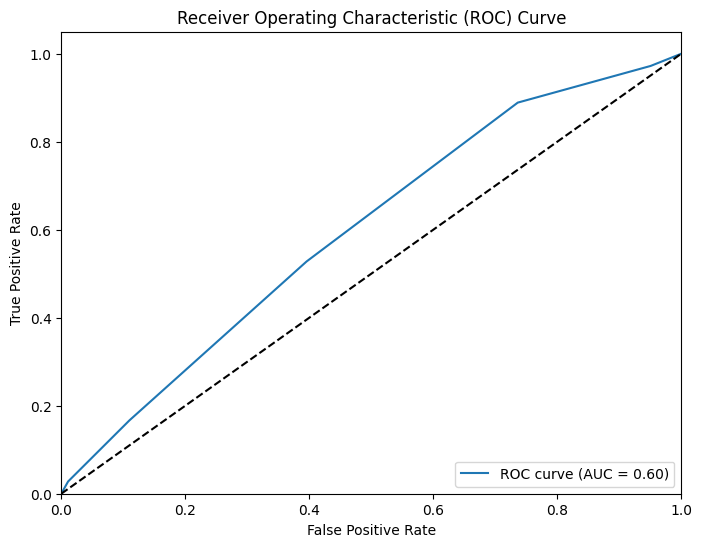

AUC-ROC Score: 0.5984


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:01:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 13
Created version '13' of model 'CreditModels'.


In [46]:
# Undersampling (RUS)
model_knn(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'n_neighbors': 1}
Model score: 0.464
Time: 19.0


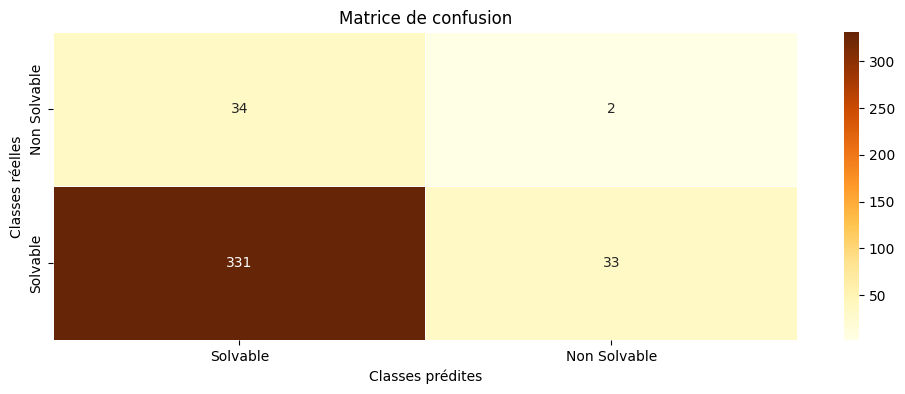

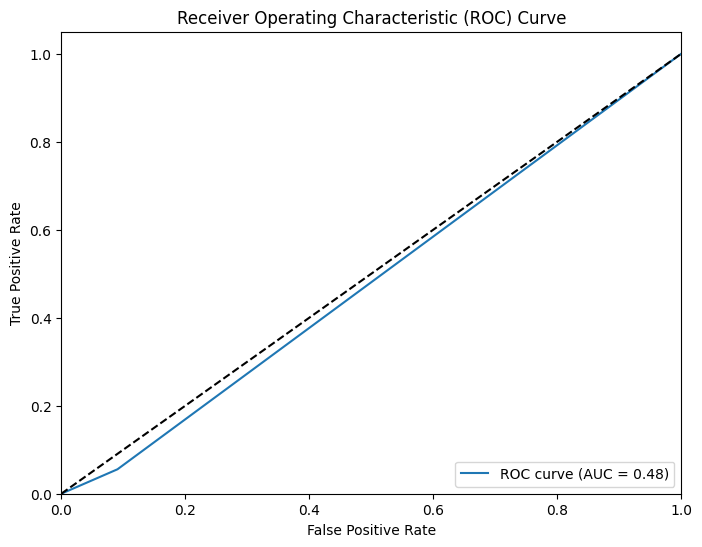

AUC-ROC Score: 0.4824


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:01:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 14
Created version '14' of model 'CreditModels'.


In [47]:
# class weight (balanced)
model_knn(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)

In [48]:
def model_dt(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'dt'
    # Params for DecisionTreeClassifier
    param_grid = [{'max_depth': [5, 10, None],
                   'min_samples_split': [2, 5, 10]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('DecisionTree Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            if use_class_weights:
                cls = DecisionTreeClassifier(class_weight='balanced')
            else:
                cls = DecisionTreeClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=metier,
                                cv=5)
            
            # Fit the model to the training data
            grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)

2023/06/23 21:01:52 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTree Models' does not exist. Creating a new experiment.


Best params:
 {'max_depth': 10, 'min_samples_split': 10}
Model score: 0.528
Time: 13.0


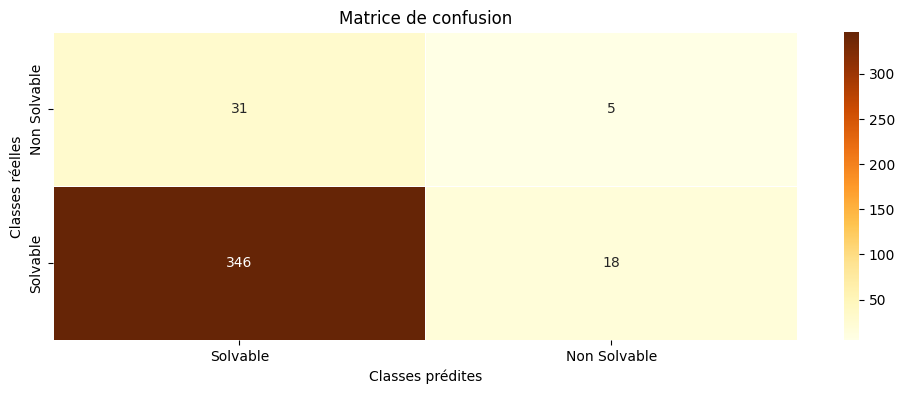

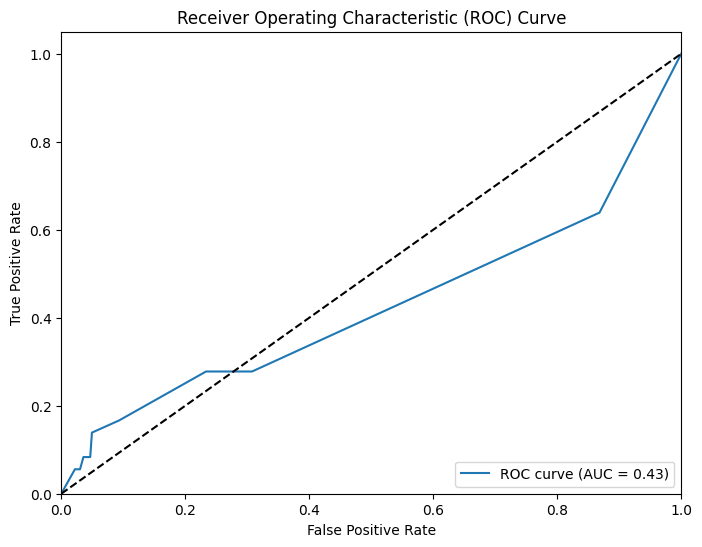

AUC-ROC Score: 0.4261


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:02:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 15
Created version '15' of model 'CreditModels'.


In [49]:
# Imbalanced data
model_dt(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample) 

Best params:
 {'max_depth': None, 'min_samples_split': 2}
Model score: 0.562
Time: 22.0


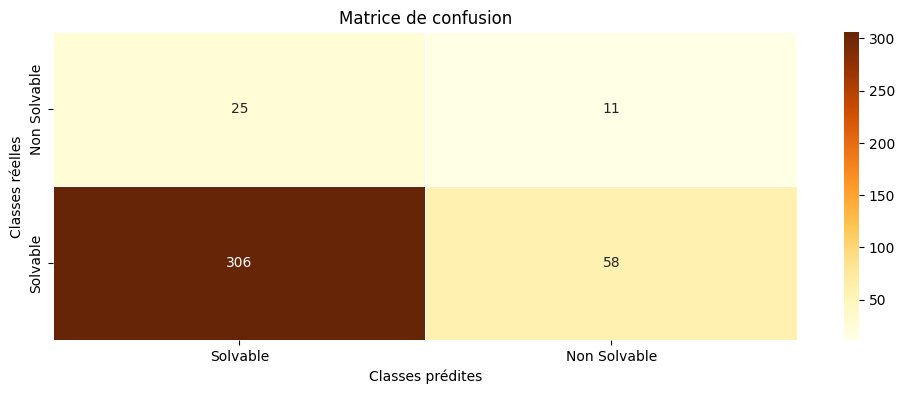

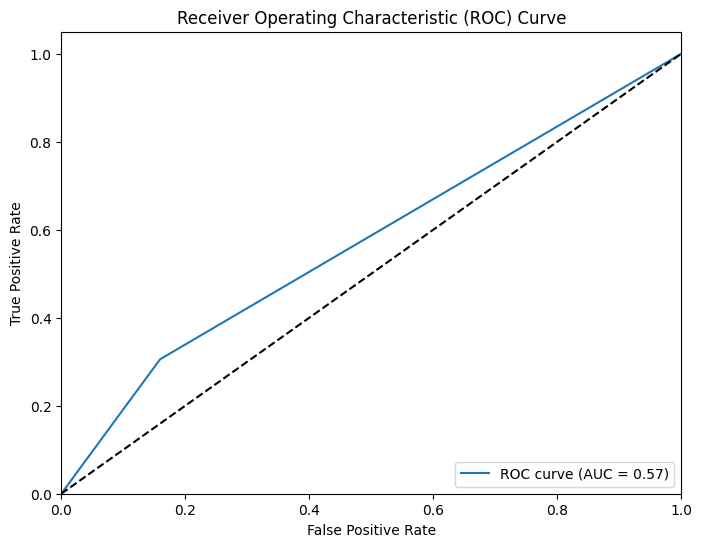

AUC-ROC Score: 0.5731


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:02:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 16
Created version '16' of model 'CreditModels'.


In [50]:
# Oversampling (SMOTE)
model_dt(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'max_depth': None, 'min_samples_split': 2}
Model score: 0.658
Time: 2.0


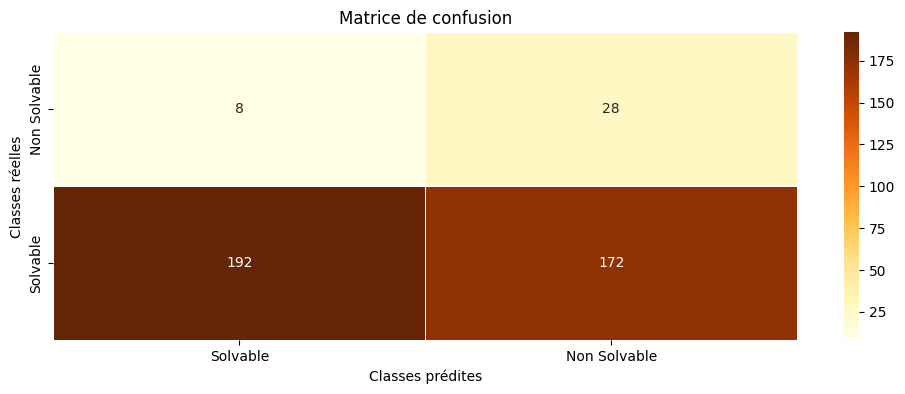

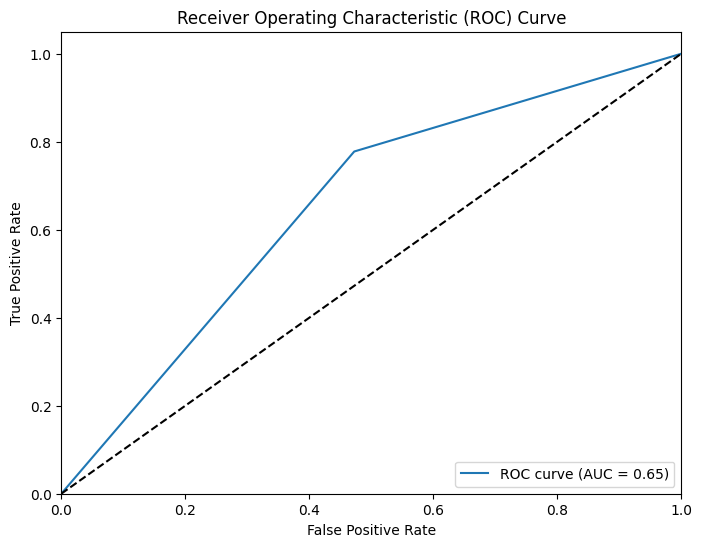

AUC-ROC Score: 0.6526


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:02:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 17
Created version '17' of model 'CreditModels'.


In [51]:
# Undersampling (RUS)
model_dt(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'max_depth': 5, 'min_samples_split': 10}
Model score: 0.518
Time: 8.0


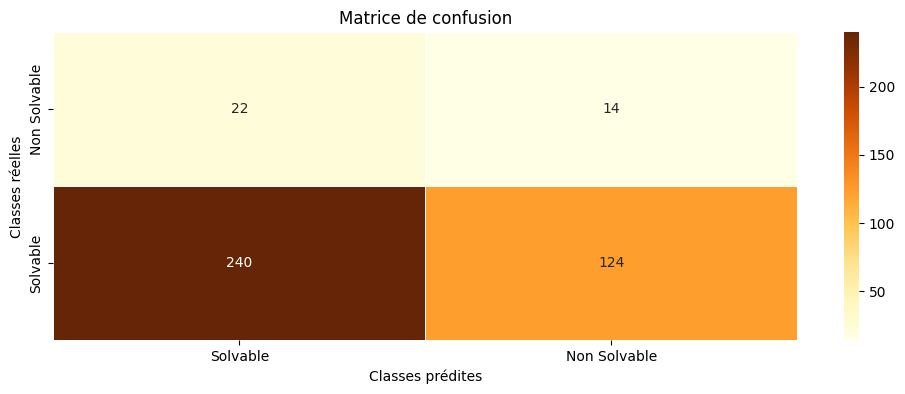

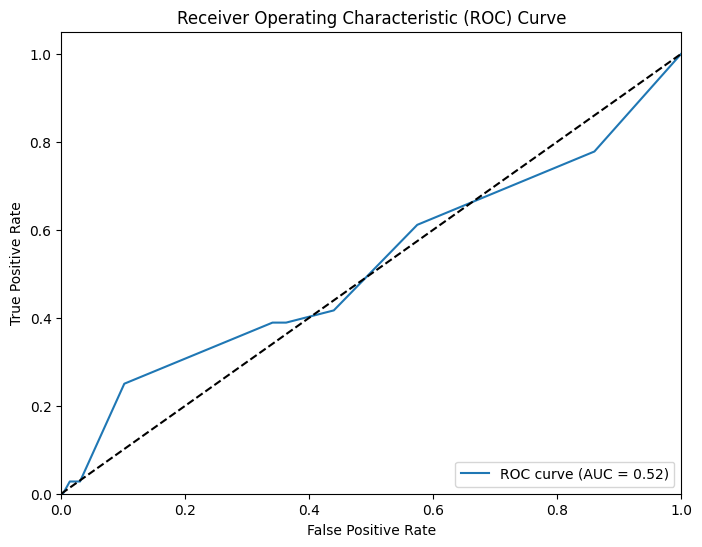

AUC-ROC Score: 0.5185


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:03:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 18
Created version '18' of model 'CreditModels'.


In [52]:
 # class weight (balanced)
model_dt(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True) 

In [53]:
def model_rf(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'rf'
    # Params for RandomForestClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [7, 9],
                   'min_samples_split': [10, 11]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('RandomF Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            if use_class_weights:
                cls = RandomForestClassifier(class_weight='balanced')
            else:
                cls = RandomForestClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=metier,
                                cv=5)
            
            # Fit the model to the training data
            grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)

2023/06/23 21:03:01 INFO mlflow.tracking.fluent: Experiment with name 'RandomF Models' does not exist. Creating a new experiment.


Best params:
 {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
Model score: 0.479
Time: 22.0


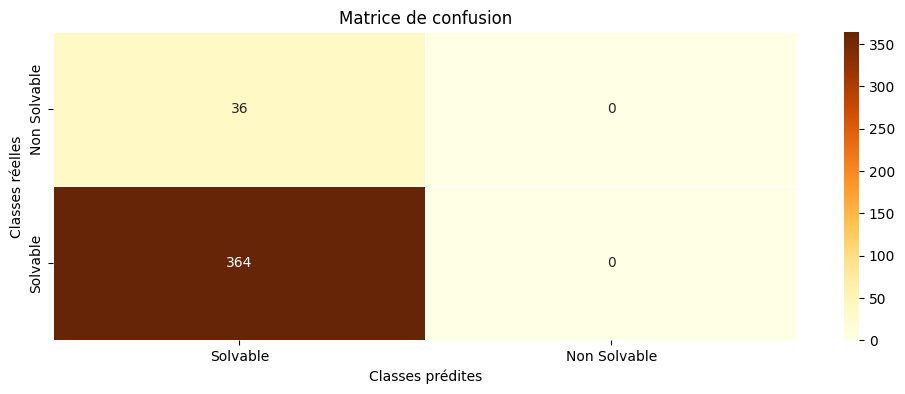

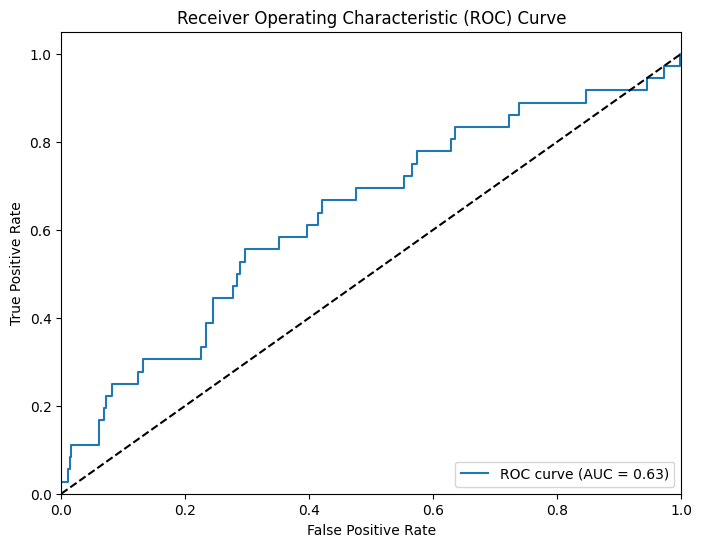

AUC-ROC Score: 0.6332


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:03:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 19
Created version '19' of model 'CreditModels'.


In [54]:
# Imbalanced data
model_rf(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'max_depth': 9, 'min_samples_split': 11, 'n_estimators': 100}
Model score: 0.504
Time: 37.0


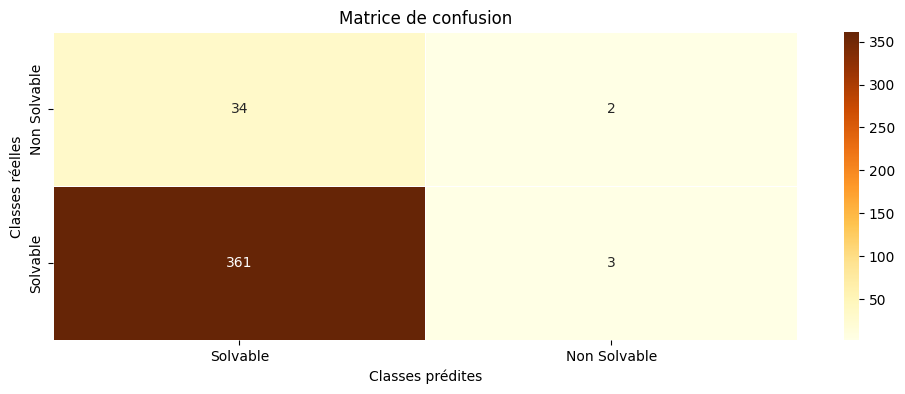

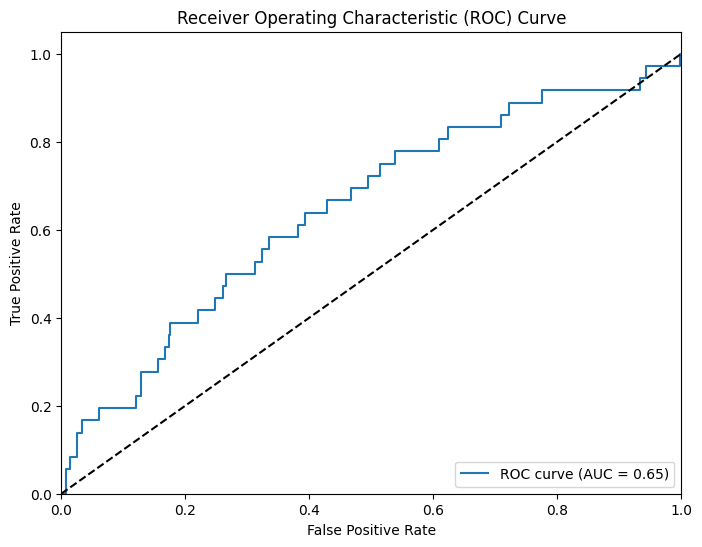

AUC-ROC Score: 0.6466


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:04:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 20
Created version '20' of model 'CreditModels'.


In [55]:
# Oversampling (SMOTE)
model_rf(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100}
Model score: 0.566
Time: 8.0


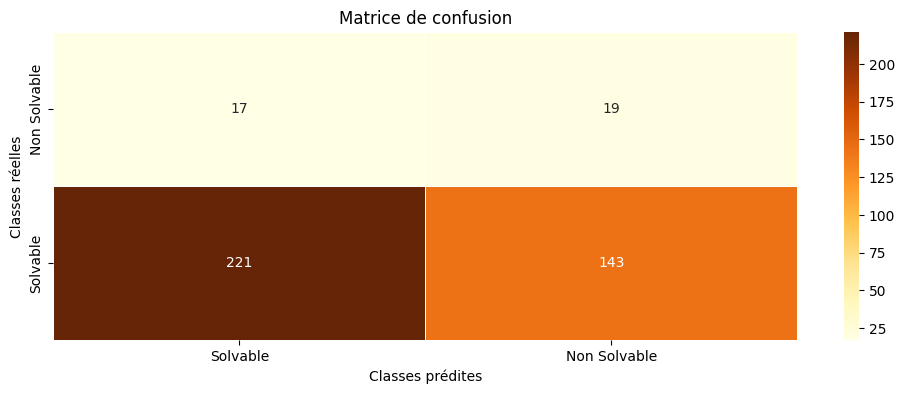

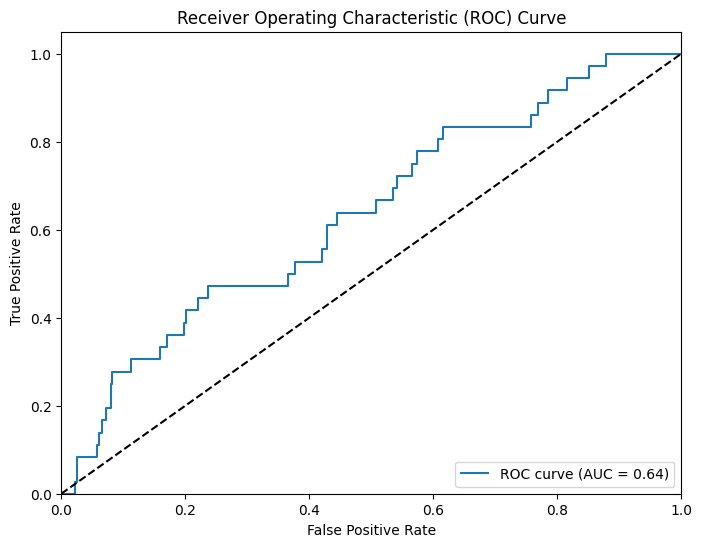

AUC-ROC Score: 0.6351


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:04:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 21
Created version '21' of model 'CreditModels'.


In [56]:
# Undersampling (RUS)
model_rf(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'max_depth': 7, 'min_samples_split': 11, 'n_estimators': 50}
Model score: 0.524
Time: 18.0


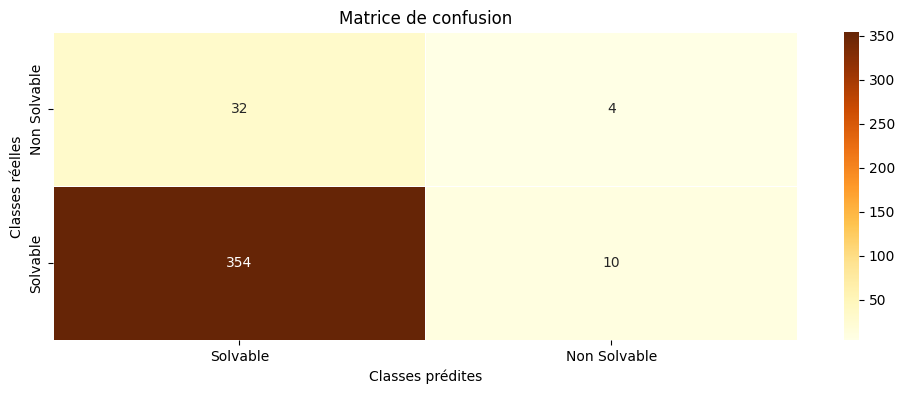

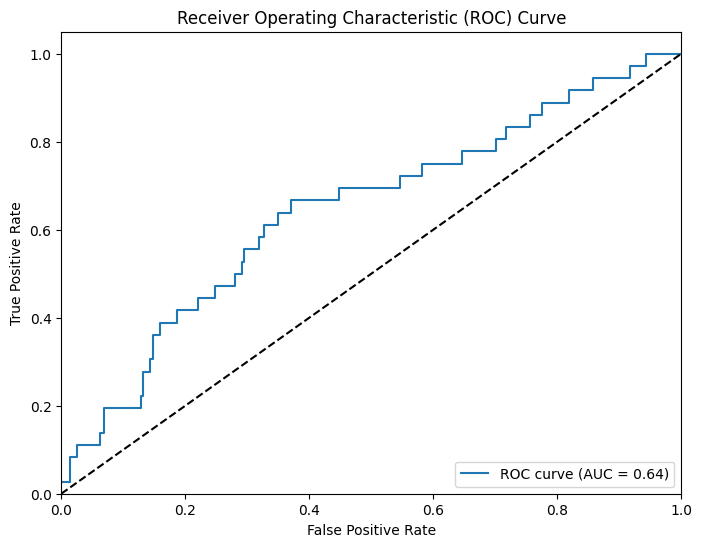

AUC-ROC Score: 0.6435


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:04:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 22
Created version '22' of model 'CreditModels'.


In [57]:
 # class weight (balanced)
model_rf(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [58]:
def model_xgb(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'xgb'
    # Params for XGBClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.05, 0.04]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            cls = XGBClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=metier,
                                cv=5)
            
            # Fit the model to the training data
            if use_class_weights:
                classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_)
                grid.fit(X_train_, y_train_, sample_weight=classes_weights)
            else:
                grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)

2023/06/23 21:04:50 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Models' does not exist. Creating a new experiment.


Best params:
 {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 50}
Model score: 0.479
Time: 72.0


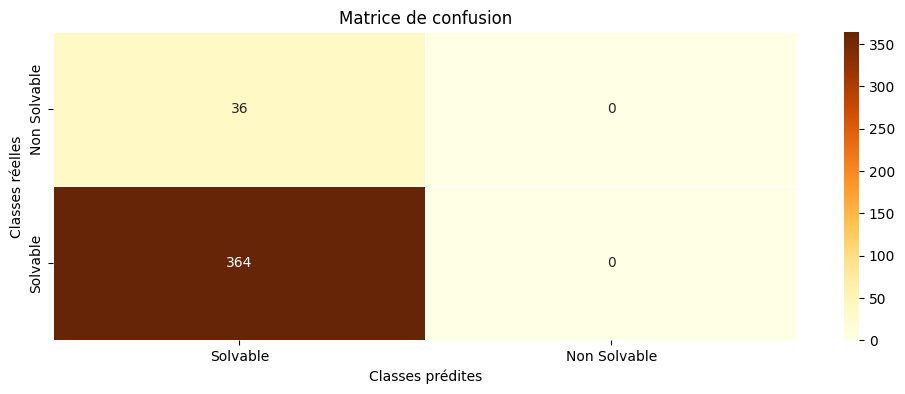

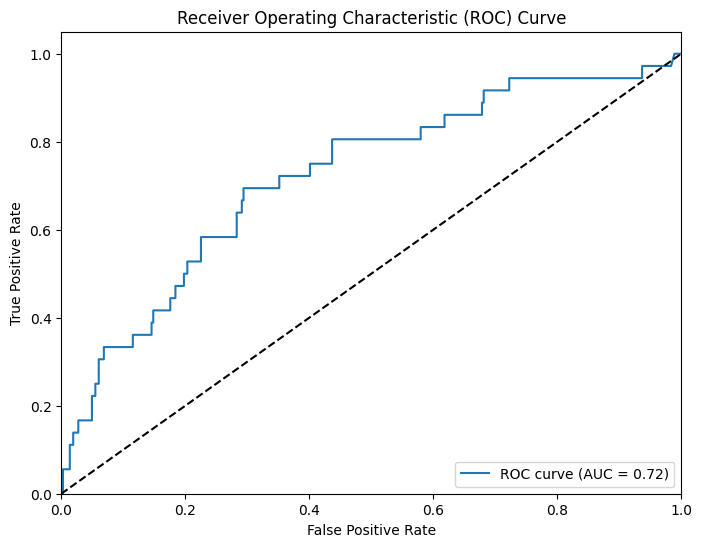

AUC-ROC Score: 0.7215


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:06:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 23
Created version '23' of model 'CreditModels'.


In [59]:
# Imbalanced data
model_xgb(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 50}
Model score: 0.479
Time: 134.0


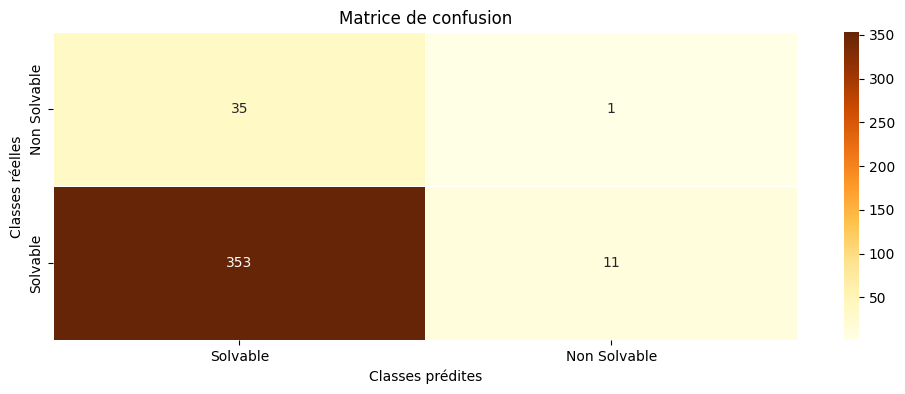

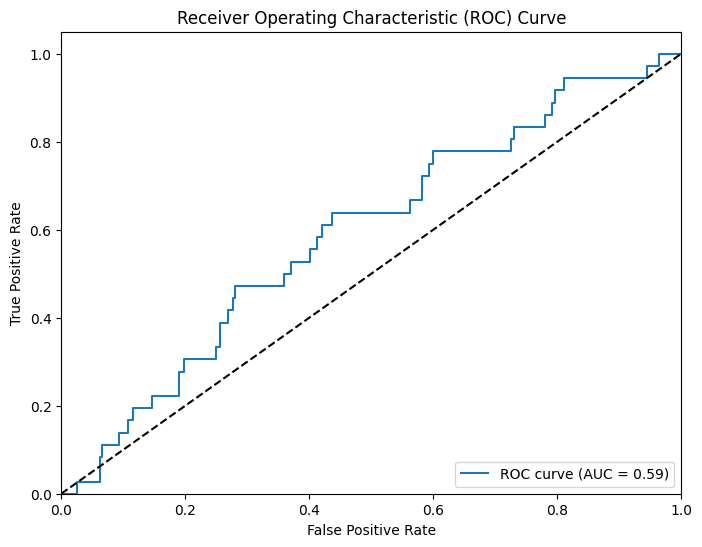

AUC-ROC Score: 0.5914


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:08:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 24
Created version '24' of model 'CreditModels'.


In [60]:
# Oversampling (SMOTE)
model_xgb(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 100}
Model score: 0.643
Time: 41.0


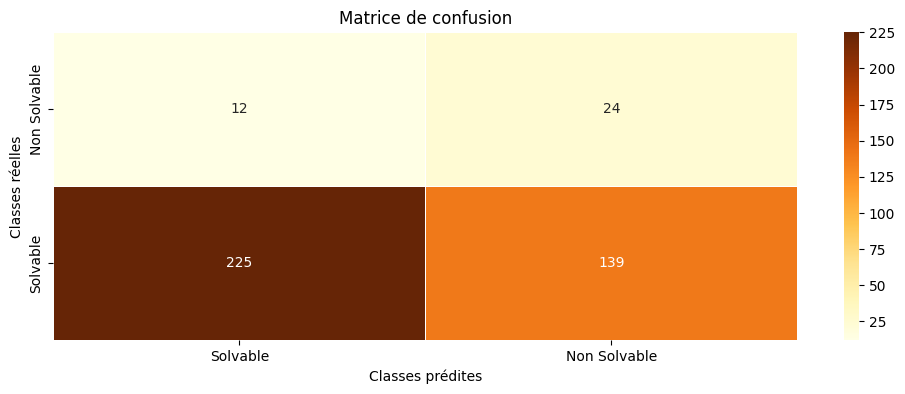

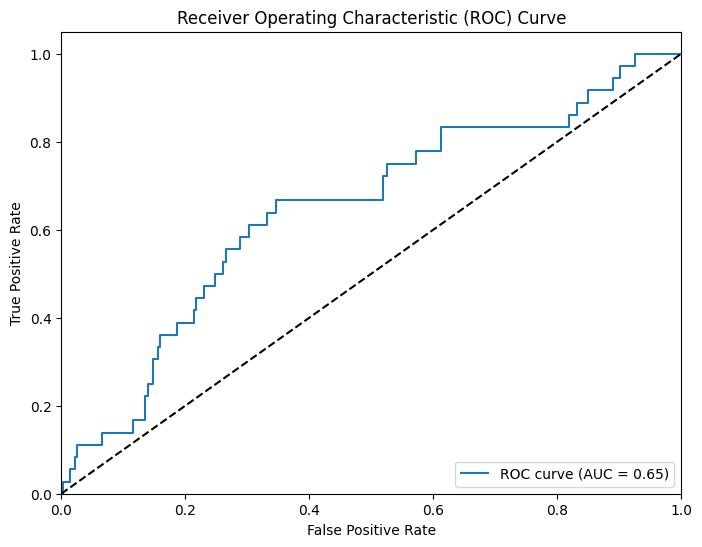

AUC-ROC Score: 0.6462


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:09:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 25
Created version '25' of model 'CreditModels'.


In [61]:
# Undersampling (RUS)
model_xgb(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Model score: 0.608
Time: 81.0


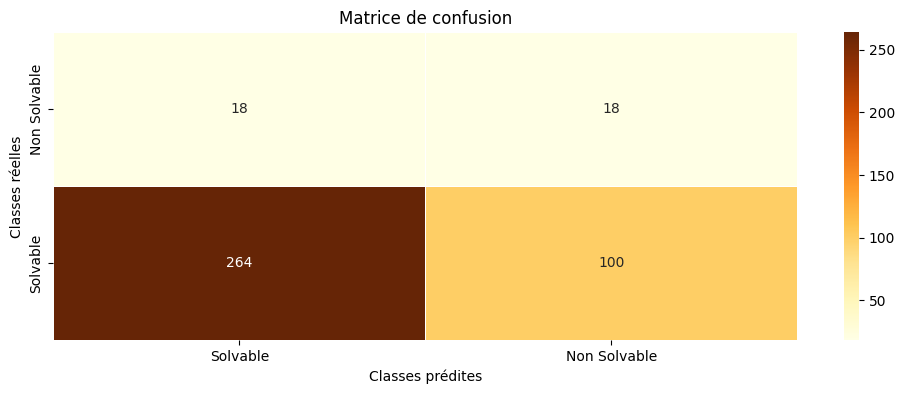

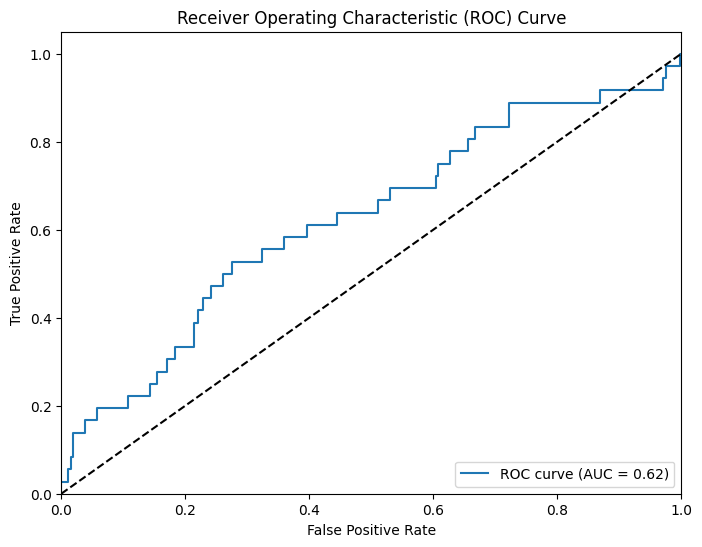

AUC-ROC Score: 0.6234


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:10:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 26
Created version '26' of model 'CreditModels'.


In [62]:
 # class weight (balanced)
model_xgb(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [63]:
df_sample.shape

(2000, 429)

# Split classique

In [64]:
df_final_without_ID = pd.read_csv(os.path.join('..','data','df_final.csv'))
df_final_without_ID.sample(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
232923,0.0,Cash loans,1,0,0,2,72000.0,198666.0,15696.0,175500.0,...,11559.575250,693574.515,3.915,90001.665,12714.759750,762885.585,-48.0,-1323.283333,-79397.0,60.0
263698,0.0,Cash loans,1,0,1,0,221400.0,247500.0,9814.5,247500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36463,0.0,Cash loans,0,0,1,0,360000.0,521136.0,54855.0,495000.0,...,4623.738750,55484.865,0.180,4630.680,3851.958750,46223.505,-752.0,-893.416667,-10721.0,12.0
279380,0.0,Cash loans,0,1,0,0,360000.0,824917.5,39816.0,724500.0,...,44156.157353,1501309.350,1116.180,45455.265,42819.237794,1455854.085,-4.0,-460.147059,-15645.0,34.0
148324,0.0,Cash loans,1,0,0,0,135000.0,628114.5,22689.0,477000.0,...,11926.170000,143114.040,11795.985,11938.005,11926.170000,143114.040,-1465.0,-1634.166667,-19610.0,12.0


In [65]:
df_final_without_ID.shape

(307507, 429)

In [66]:
X = df_final_without_ID.drop('TARGET',axis=1)
y = df_final_without_ID['TARGET']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

In [68]:
X_train.shape,X_test.shape

((246005, 428), (61502, 428))

In [69]:
del df_final_without_ID,df_sample

In [70]:
categorical_list_2 = []
numerical_list_2 = []

# Identify categorical and numerical columns
for i in X_train.columns.tolist():
    if X_train[i].dtype == 'object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)

# Create and fit SimpleImputer on numerical columns
simple_imputer = SimpleImputer(strategy='median').fit(X_train[numerical_list_2])

# Infer signature for the imputer model
signature = infer_signature(X_train, y_train)

# Save the imputer model using MLflow
mlflow.sklearn.save_model(simple_imputer, 'imputer', signature=signature)

2023/06/23 21:11:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# Modèle final

In [71]:
def model_xgb_final(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'xgb_final'
    # Params for XGBClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.05, 0.04]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            cls = XGBClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=metier,
                                cv=5)
            
            # Fit the model to the training data
            if use_class_weights:
                classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_)
                grid.fit(X_train_, y_train_, sample_weight=classes_weights)
            else:
                grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)
            return grid.best_params_

Best params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Model score: 0.608
Time: 80.0


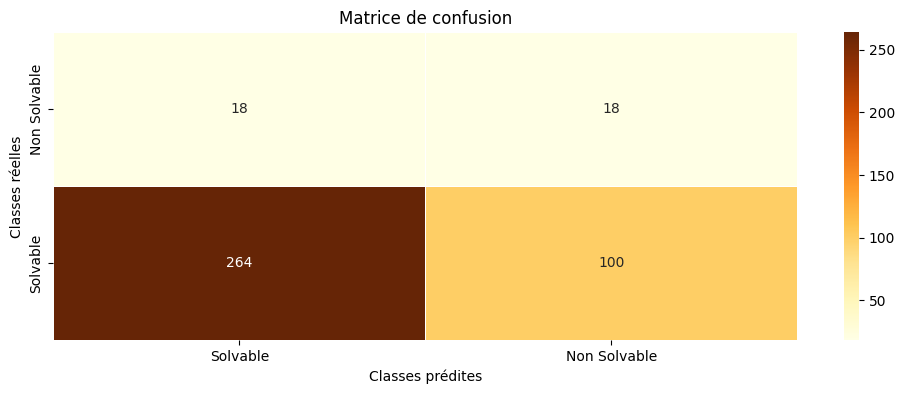

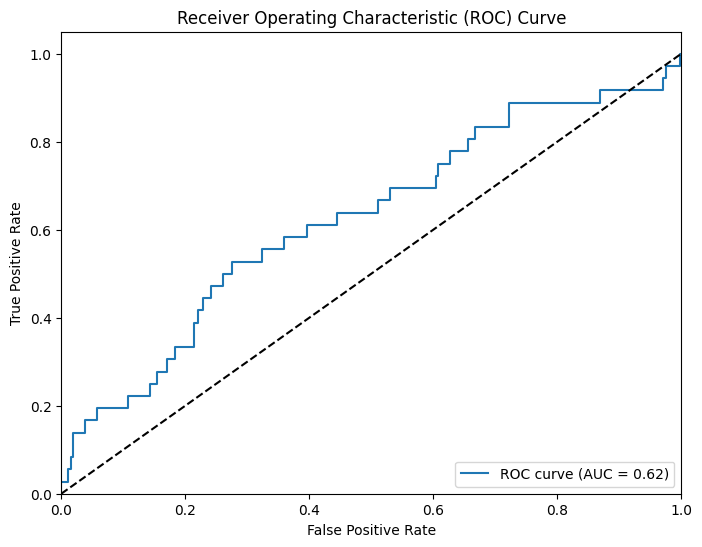

AUC-ROC Score: 0.6234


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/06/23 21:13:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 27
Created version '27' of model 'CreditModels'.


In [72]:
 # class weight (balanced)
best_params = model_xgb_final(X_train_rus, X_test_prepro, y_train_rus, y_test_sample, use_class_weights=False)  

In [73]:
best_params

{'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}

# Préparation au déploiement

In [74]:
pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('classifier', XGBClassifier(**best_params))])

In [75]:
# pipeline.fit(X_train_prepro,y_train_sample)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELA

# Définition du seuil

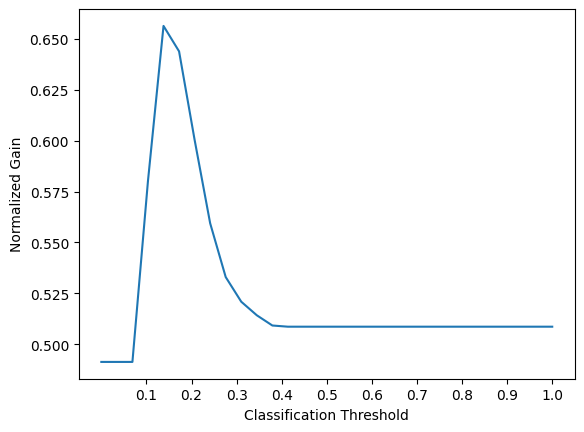

In [76]:
threshold_x = np.linspace(0.0, 1, 30)
cost_function = []

for threshold in threshold_x:
    # Calculate y_pred based on threshold
    y_scores = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > threshold).astype(int)
    
    # Calculate the eva_func score
    cost_function.append(eva_func(y_test, y_pred))

# Plot the normalized gain
plt.plot(threshold_x, cost_function)
plt.xlabel("Classification Threshold")
plt.ylabel("Normalized Gain")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

In [77]:
threshold = []
for thresh, cost in zip(threshold_x, cost_function):
    if cost == max(cost_function):
        threshold.append(thresh)

# Modify predictions using manual threshold adjustment
y_pred = pipeline.predict_proba(X_test)
y_pred = (y_pred[:, 1] >= threshold) * 1
threshold[0]

0.13793103448275862

In [78]:
name = 'xgb_threshold/' + str(threshold[0])

# Set the path where it is stored
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set the name of the experiment folder
mlflow.set_experiment('XGBoost Models')

# Initialise counting time
time1 = time.time()

# Executed as a script
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(42)
    # Give the run a name
    with mlflow.start_run(run_name=name) as run:
        
        # Return all metrics
        print('Scores après application du threshold :')
        for k, v in zip(eval_metrics(y_test, y_pred).keys(), eval_metrics(y_test, y_pred).values()):
            print('{} : {:.3f}'.format(k, v))
        print("score custom metric : %.3f" % eva_func(y_test, y_pred))
        
        time2 = np.round(time.time() - time1, 0)


Scores après application du threshold :
balance_accuracy : 0.656
f1 : 0.238
roc_auc : 0.656
accuracy_score : 0.667
fbeta_score : 0.479
score custom metric : 0.656


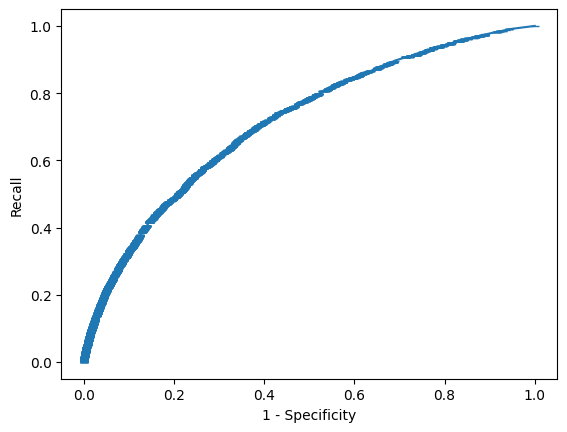

In [79]:
[fpr, tpr, thr] = roc_curve(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:, 1])

# ROC curve
plt.plot(fpr, tpr, marker="_")
plt.xlabel('1 - Specificity')
plt.ylabel('Recall')
plt.show()


In [80]:
# Enregistrement du modèle 
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipeline, 'MLFlow Best Model', signature=signature)

# SHAP Values

In [81]:
categorical_list_2 = []
numerical_list_2 = []
for i in X_train.columns.tolist():
    if X_train[i].dtype=='object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)
        
# Récupérer le nom des catégories
cat = pipeline['preprocessor'].transformers_[1][1]\
      .get_feature_names_out(categorical_list_2)

# Enregistrer le model
classifier = pipeline.named_steps['classifier']

# Nom de l'ensemble des colonnes preprocessed
column_names = numerical_list_2+cat.tolist()

In [82]:
# Generate global Shapley Values
# Preprocess the data
df_preprocess = pd.DataFrame(pipeline.named_steps['preprocessor'].transform(X_train),
                             columns=column_names)

# Get the classifier from the pipeline
classifier = pipeline.named_steps['classifier']

# Create an explainer using the classifier and preprocessed data
explainer = shap.Explainer(classifier, df_preprocess)

# Calculate Shapley values for the preprocessed data
# Set check_additivity=False to disable additivity check
shap_values = explainer(df_preprocess, check_additivity=False)

100%|===================| 245386/246005 [04:49<00:00]        

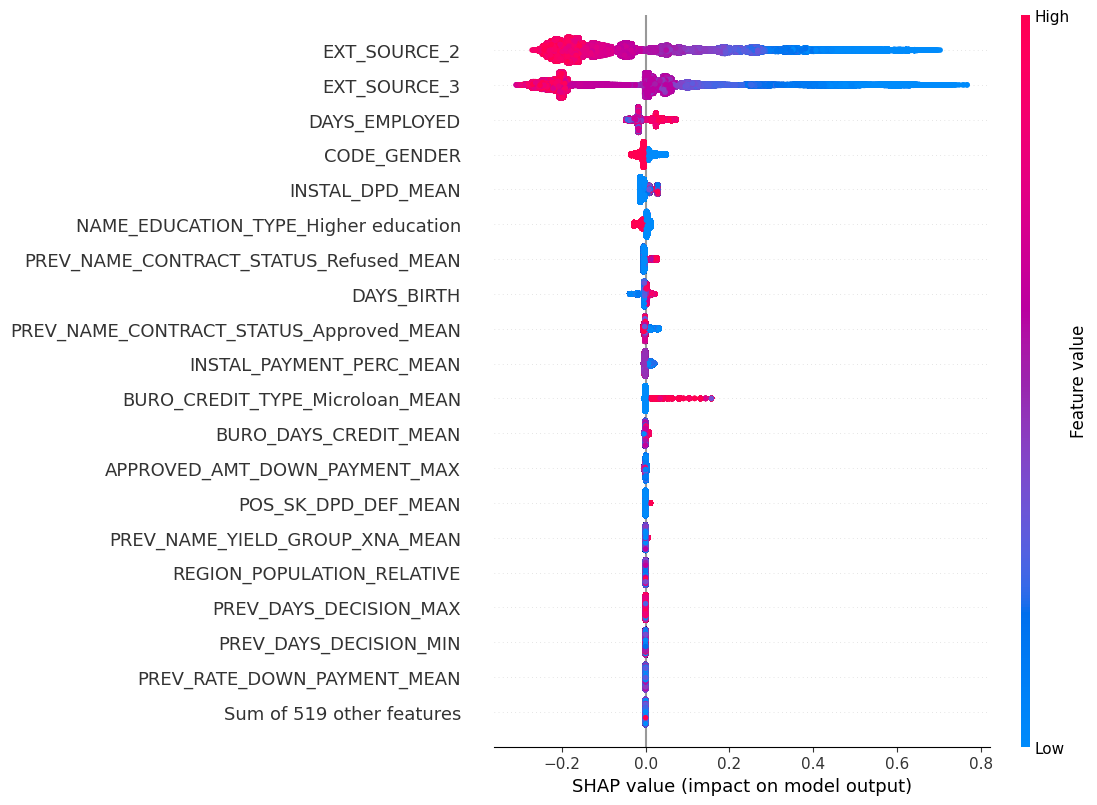

In [83]:
# Afficher interpretabilité globale
shap.plots.beeswarm(shap_values,max_display=20)

In [84]:
# Generate Shapley values for a specific client
# Get the client ID from the X_train index
client_id = X_train.index.tolist()[0]

# Create a list of all IDs in X_train
list_ID = X_train.index.tolist()

# Initialize an empty list to store the indices of the client's ID
index_ID = []

# Iterate over the list of IDs and find the indices that match the client ID
for ind, ID in enumerate(list_ID):
    if list_ID[ind] == client_id:
        index_ID.append(ind)

# Extract the Shapley values for the client using the obtained indices
shap_values_client = shap_values[index_ID][0]


In [85]:
client_id

40682

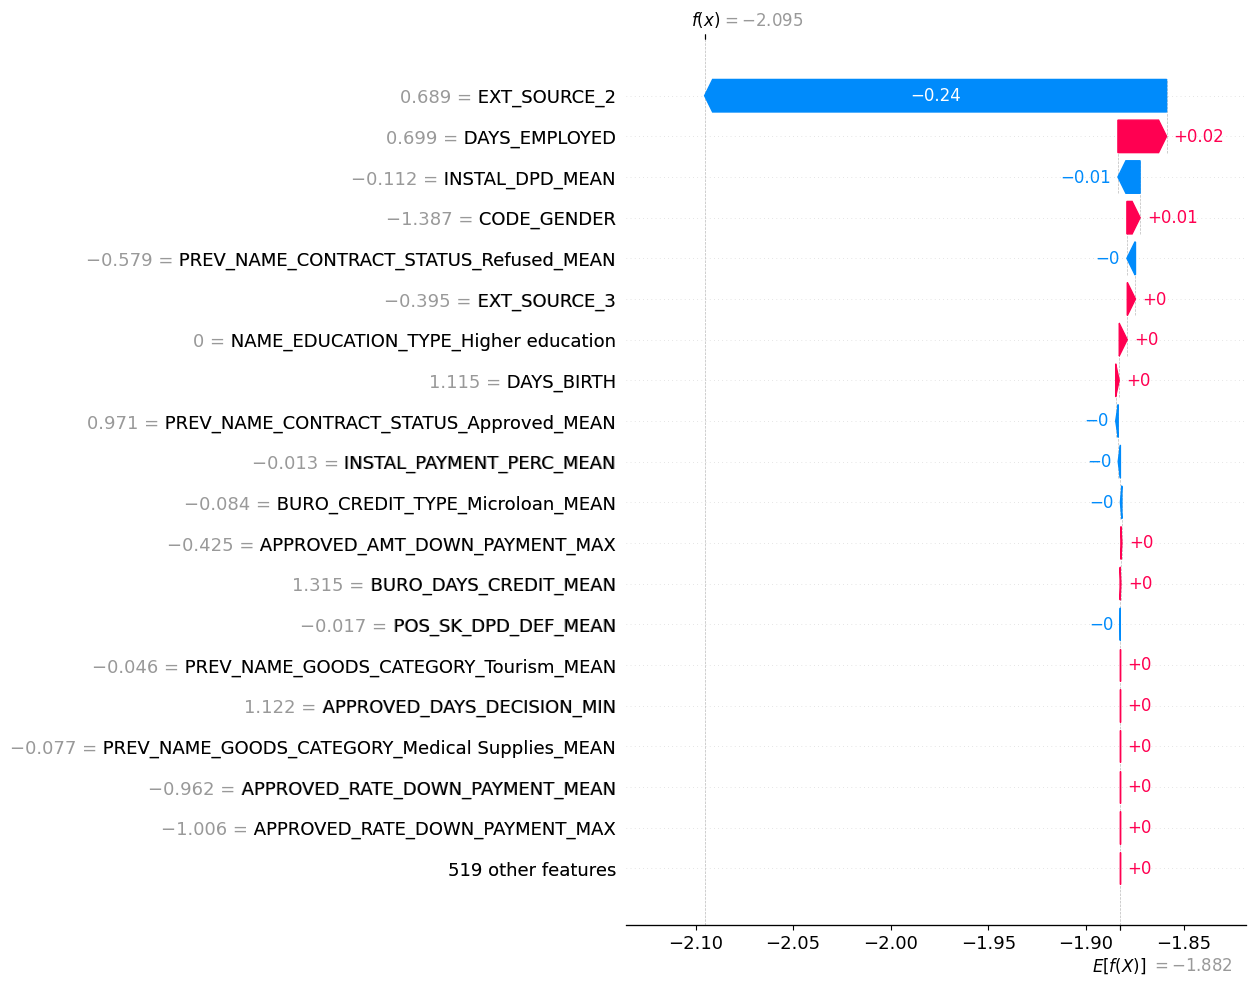

In [86]:
# Afficher interpretabilité locale
shap.plots.waterfall(shap_values_client,max_display=20)